In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')
import pickle

In [2]:
with open("robust_1.bin", "rb") as f:
    df = pickle.load(f)
    
features = df["features"]
T = df["T"]
Tsec = df["Tsec"]
frame_w = df["frame_w"]
frame_h = df["frame_h"]
    
Ny, Nx, Nbins = features[0][2].shape
Ndirs = Nbins - 1
cell_size = int(frame_w / Nx)
assert(cell_size == int(frame_h / Ny))

Nt = len(features)

bcd_arr = []

for i in range(Nt):
    bcd_arr.append(features[i][2])
    
bcd_arr = np.array(bcd_arr)    

print("bcd_arr.shape", bcd_arr.shape)
print("Nt", Nt)
print("Nx, Ny, Ndirs", Nx, Ny, Ndirs)
print("h, w, T", frame_w, frame_h, T)
print("cell_size", cell_size)

bcd_arr.shape (10, 15, 20, 9)
Nt 10
Nx, Ny, Ndirs 20 15 8
h, w, T 320 240 50
cell_size 16


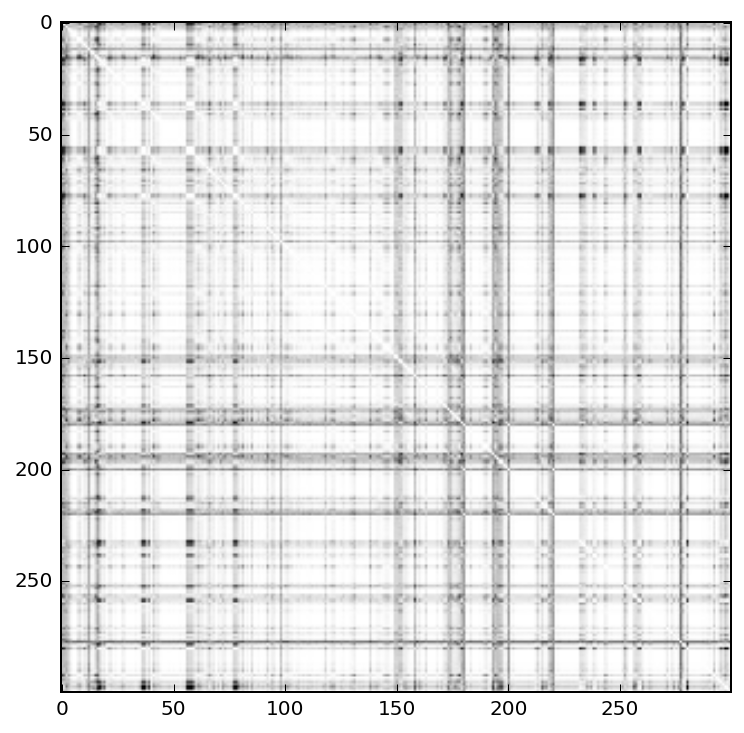

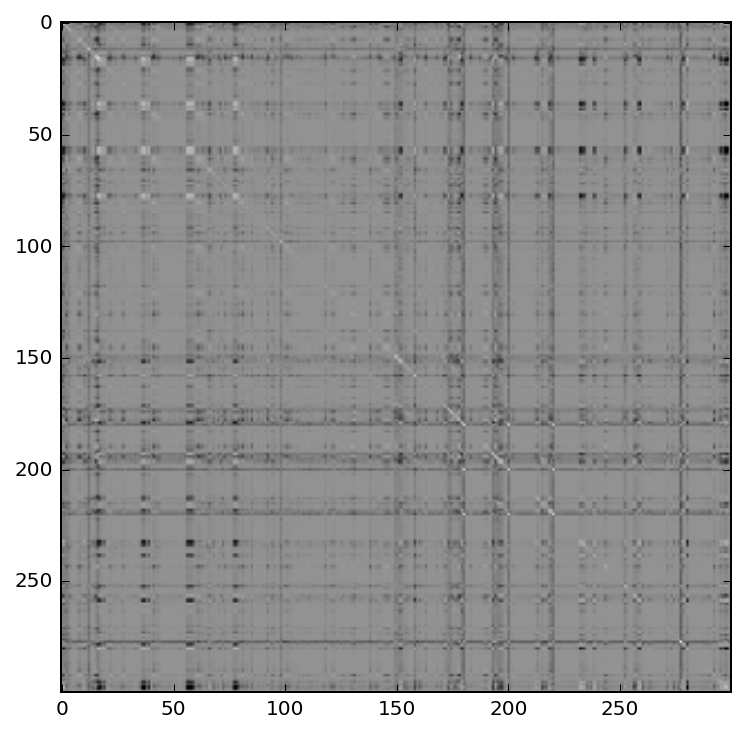

In [3]:
Ncells = Nx * Ny
R = 111111115.0

def cell2xy(idx):
    y = int(idx / Nx)
    x = idx - y * Nx
    return np.array([np.float64(x), np.float64(y)])

Dij_bcd = np.zeros((Ncells, Ncells), np.float64)
Dij_dist = np.zeros((Ncells, Ncells), np.float64)

for i in range(Ncells):
    for j in range(Ncells):
        ci = cell2xy(i)
        cj = cell2xy(j)
        mag = np.linalg.norm(ci - cj)
        bcd1 = bcd_arr[:, int(ci[1]), int(ci[0]), :]
        bcd2 = bcd_arr[:, int(cj[1]), int(cj[0]), :]                                                
        Dij_bcd[i, j] = distance.cosine(bcd1.flatten(), bcd2.flatten())
        #Dij_bcd[i, j] = np.linalg.norm(bcd1.flatten() - bcd2.flatten())
        Dij_dist[i, j] = mag
        #Dij_dist[i, j] = distance.cosine(ci, cj)
            
Aij = np.zeros((Ncells, Ncells), np.float64)
        
sigmaBCD = np.zeros(Aij.shape[0], np.float64)
sigmaDIST = np.zeros(Aij.shape[0], np.float64)
for i in range(Aij.shape[0]):
    row = np.sort(Dij_bcd[i, :])
    row = np.trim_zeros(row)
    sigmaBCD[i] = row[6]
    
    #row = Dij_bcd[i, :]
    #gm1 = GaussianMixture(n_components=1, covariance_type='diag')    
    #gm1.fit(row.reshape(-1, 1))
    #sigmaBCD[i] = gm1.covariances_[0][0]
    
    row = np.sort(Dij_dist[i, :])
    row = np.trim_zeros(row)
    sigmaDIST[i] = row[6]
    
    #row = Dij_dist[i, :]
    #gm1 = GaussianMixture(n_components=1, covariance_type='diag')    
    #gm1.fit(row.reshape(-1, 1))
    #sigmaDIST[i] = gm1.covariances_[0][0]
    
for i in range(Aij.shape[0]):
    for j in range(Aij.shape[0]):
        ci = cell2xy(i)
        cj = cell2xy(j)        
        mag = np.linalg.norm(ci - cj)
        if (mag <= R):            
            #Aij[i, j] = np.exp((-1.0 * (Dij_bcd[i,j]**2.0)) / (sigmaBCD[i] * sigmaBCD[j]) +
             #                  (-1.0 * (Dij_dist[i,j]**2.0)) / (sigmaDIST[i] * sigmaDIST[j]))
            Aij[i, j] = np.exp(-1.0 * (Dij_bcd[i,j]**2.0))
        else:
            Aij[i, j] = 10000
            
plt.figure()
plt.imshow(Aij, cmap='gray')
plt.show()

D = np.diag(Aij.sum(axis=1)**-0.5)
                
_L = np.dot(D,Aij)
L = np.dot(_L,D)
Anorm = L

plt.figure()
plt.imshow(Anorm, cmap='gray')
plt.show()

42


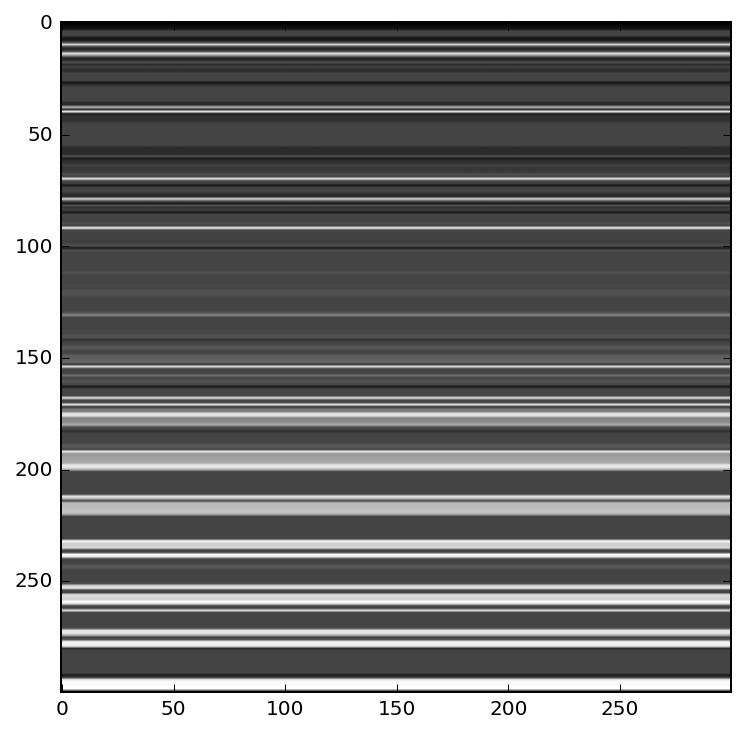

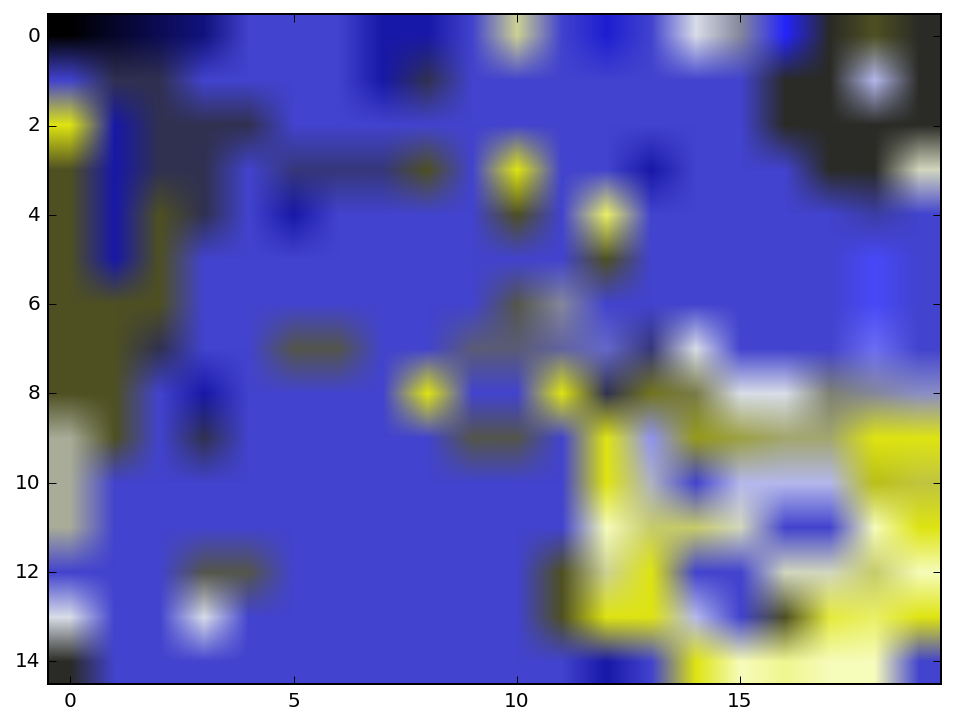

In [4]:
from sklearn.cluster import AffinityPropagation

def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

af = AffinityPropagation(affinity='precomputed').fit(Aij)

finalK2 = len(af.cluster_centers_indices_)
print(finalK2)

AM = np.zeros((Ncells, Ncells), np.float64)
for i in range(Ncells):            
    for j in range(Ncells):            
        AM[i, j] = af.labels_[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

clrs = np.zeros((Ny, Nx, 3), np.uint8)

cc = get_spaced_colors(finalK2)

for i in range(finalK2):
    for j in range(Ncells):
        if af.labels_[j] == i:
            c = cell2xy(j)
            clrs[int(c[1]), int(c[0]), 0] = cc[i][0]
            clrs[int(c[1]), int(c[0]), 1] = cc[i][1]
            clrs[int(c[1]), int(c[0]), 2] = cc[i][2]
            
plt.figure()
plt.imshow(clrs)
plt.show()

Km= 20
(300, 20)
0.422761180692
0.49113221463
0.48306745441
0.509818148417
0.536716615647
0.428195020444
0.225671984476
0.634591457832
0.414587410859
0.411780655163
0.520337425746
0.389735338053
0.485593578442
0.208443551424
0.131540783392
0.428713813354
0.564372996492
0.112571940456
0.854922725756
0.27425911559
New Km= 6
(300, 6)
1 -13406.5627481 inf
2 -13707.8366041 0.0219782205408
3 -14475.5850165 0.0530374704352
4 -14412.1964053 0.00439826167797
5 -14376.5539189 0.00688837520479
6 -14266.8626533 0.0146298712072
3


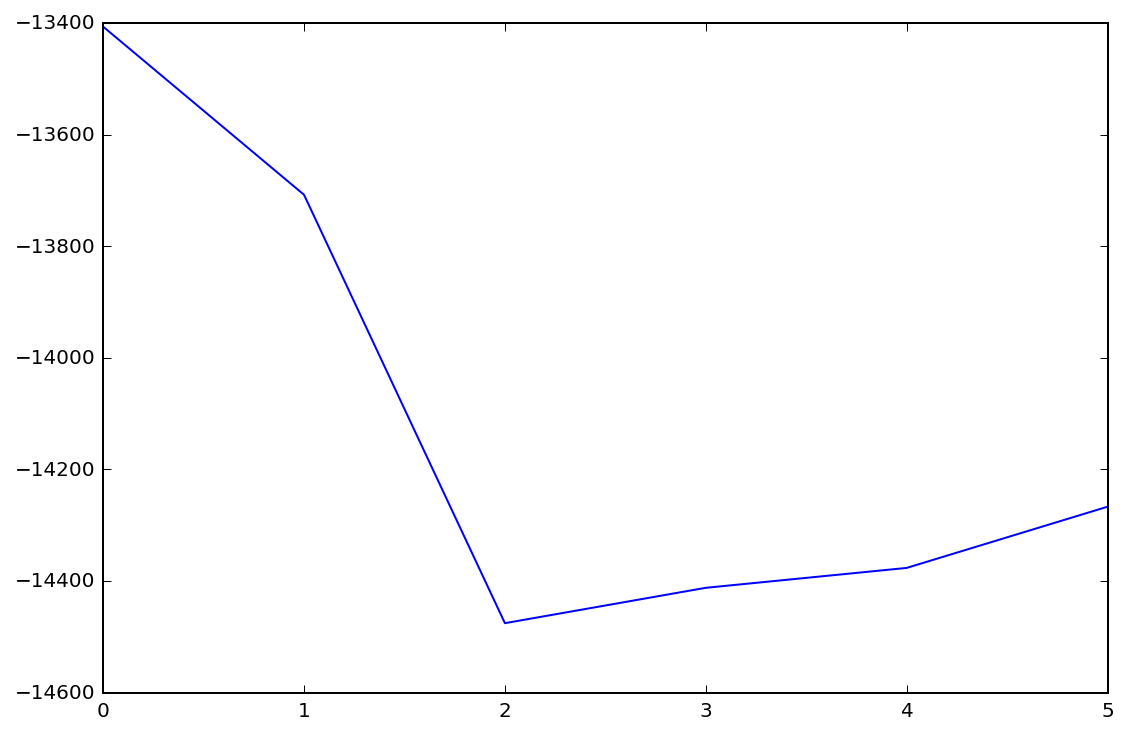

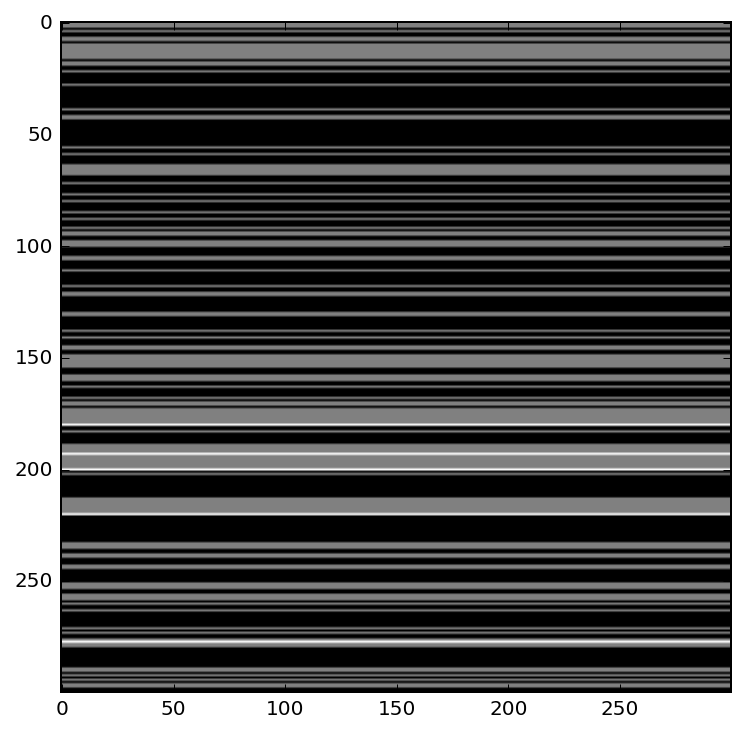

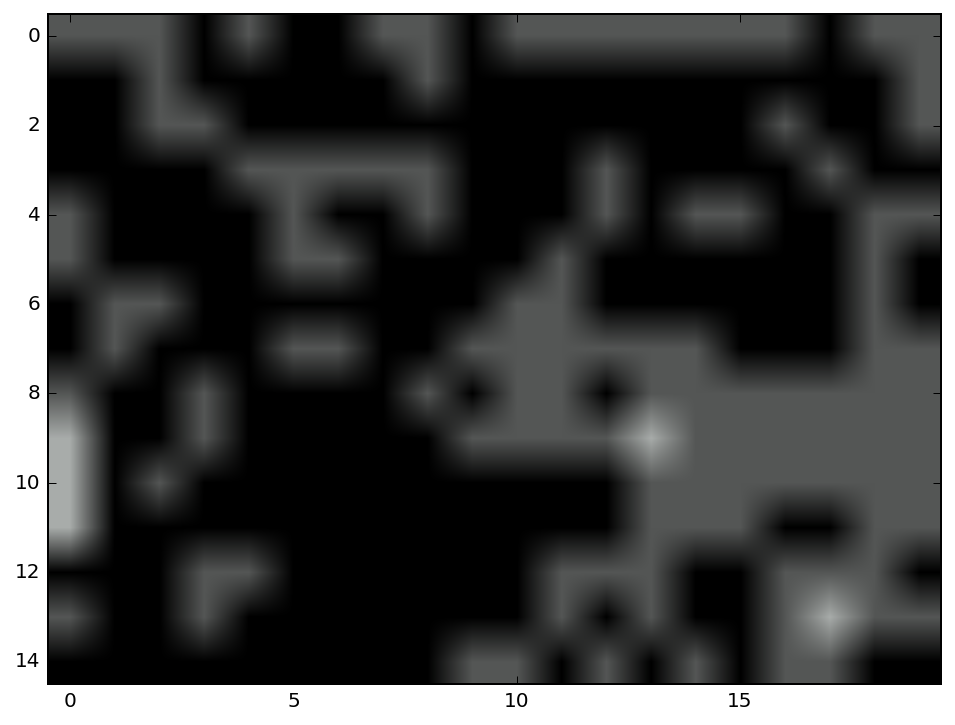

In [5]:
def classify1(features, MX, stop_imm = True, tp = 'full'):
    newdata = features
    n_components = np.arange(1, MX + 1)
    BIC = np.zeros(n_components.shape)
    lowest_bic = np.infty
    best_gmm = None

    for i, n in enumerate(n_components):        
        gmm = GaussianMixture(n_components=n, covariance_type=tp, random_state=0)
        gmm.fit(newdata)
        BIC[i] = gmm.bic(newdata)
        dbic = np.abs(BIC[i] - lowest_bic) / np.abs(BIC[i])
        print(n, BIC[i], dbic)
        if BIC[i] < lowest_bic:
        #if dbic >= 1e-3:        
            lowest_bic = BIC[i]
            best_gmm = gmm
        elif stop_imm:
            break

    best_gmm = GaussianMixture(n_components=best_gmm.n_components, covariance_type=tp, random_state=0)
    best_gmm.fit(features)

    print(best_gmm.n_components)
    plt.figure()
    plt.plot(BIC)
    plt.show()
    return best_gmm

import mixem

Km = int(Ncells / 5)
Km = np.min(np.array([Km, 20]))

Snorm_vals, Snorm_vecs = np.linalg.eigh(Aij)

Snorm_vecs = Snorm_vecs.T

for i in range(len(Snorm_vecs)):
    Snorm_vecs[i, :] *= Snorm_vals[i]
    #Snorm_vecs[i, :] *= 1000

indices = np.argsort(Snorm_vals)[::-1][:Km]
#indices = list(range(N-Km, N))[::-1]

top_vecs = Snorm_vecs[indices].T

assert(Ncells == len(top_vecs))

print("Km=",Km)
print(top_vecs.shape)

def my_em(data, distributions, initial_weights=None, max_iterations=100, tol=1e-15, tol_iters=10, progress_callback=mixem.simple_progress):    
    n_distr = len(distributions)
    n_data = data.shape[0]

    if initial_weights is not None:
        weight = np.array(initial_weights)
    else:
        weight = np.ones((n_distr,))

    last_ll = np.zeros((tol_iters, ))
    resp = np.empty((n_data, n_distr))
    log_density = np.empty((n_data, n_distr))
    
    Rk = 0

    iteration = 0
    while True:
        # E-step #######

        # compute responsibilities
        for d in range(n_distr):
            log_density[:, d] = distributions[d].log_density(data)

        # normalize responsibilities of distributions so they sum up to one for example
        resp = weight[np.newaxis, :] * np.exp(log_density)
        resp /= np.sum(resp, axis=1)[:, np.newaxis]

        log_likelihood = np.sum(resp * log_density)

        # M-step #######
        h1 = resp[:, 0]
        h2 = resp[:, 1]
        h3 = resp[:, 2]
                                                
        for d in range(n_distr):            
            if d != 0:
                distributions[d].estimate_parameters(data, resp[:, d])
                distributions[d].sigma += 1e-6
                
        Rk = 1.0 - np.mean(h1)
        wk = np.mean(h2) / Rk
        
        weight[0] = 1.0 - Rk
        weight[1] = wk*Rk
        weight[2] = (1.0 - wk)*Rk
        
        assert(np.allclose(np.sum(weight), 1.0))

        if progress_callback:
            progress_callback(iteration, weight, distributions, log_likelihood)

        # Convergence check #######
        if np.isnan(log_likelihood):
            last_ll[0] = log_likelihood
            break

        if iteration >= tol_iters and np.abs(log_likelihood - last_ll[-1]) / np.abs(log_likelihood) <= tol:
            last_ll[0] = log_likelihood
            break

        if iteration >= max_iterations:
            last_ll[0] = log_likelihood
            break

        # store value of current iteration in last_ll[0]
        # and shift older values to the right
        last_ll[1:] = last_ll[:-1]
        last_ll[0] = log_likelihood

        iteration += 1

    return Rk, distributions, last_ll[0]

new_top_vecs = []
new_rks = []

for i in range(Km):
    mk1 = np.sum(top_vecs[:, i]) * (1.0 / Ncells)
    sigma_k1 = np.sqrt(np.sum((top_vecs[:, i] - mk1) ** 2) * (1.0 / Ncells))    
                            
    gm1 = GaussianMixture(n_components=1, covariance_type='diag', means_init=[[mk1]], precisions_init=[[1.0 / (sigma_k1 * sigma_k1)]])
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
            
    dist0 = mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0]))
                
    gm1 = GaussianMixture(n_components=2, covariance_type='diag')
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
                    
    max_ds = [
        dist0,
        mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0])),
        mixem.distribution.NormalDistribution(gm1.means_[1][0], np.sqrt(gm1.covariances_[1][0]))]
            
    max_ws = [0.5, gm1.weights_[0] * 0.5, gm1.weights_[1] * 0.5]
        
    Rk, ds, ll = my_em(top_vecs[:, i], max_ds,
        initial_weights = max_ws, progress_callback=None,
        tol_iters=100, max_iterations=10000, tol=1e-6)
        
    print(Rk)
    if (Rk >= 0.5):
        new_top_vecs.append(top_vecs[:, i])
        new_rks.append(Rk)
                
top_vecs = np.array(new_top_vecs)
new_rks = np.array(new_rks)

new_rks /= np.sum(new_rks)

for i in range(len(top_vecs)):
    top_vecs[i, :] *= new_rks[i]

Km = len(top_vecs)
print("New Km=",Km)
top_vecs = top_vecs.T
print(top_vecs.shape)

eig_gmm = classify1(top_vecs, Km, False)

finalK = eig_gmm.n_components

top_classes = eig_gmm.predict(top_vecs)

AM = np.zeros((Ncells, Ncells), np.float64)
for i in range(Ncells):            
    for j in range(Ncells):            
        AM[i, j] = top_classes[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

clrs = np.zeros((Ny, Nx, 3), np.uint8)

cc = get_spaced_colors(finalK)

top_classes = eig_gmm.predict(top_vecs)

for i in range(finalK):
    for j in range(Ncells):
        if top_classes[j] == i:
            c = cell2xy(j)
            clrs[int(c[1]), int(c[0]), 0] = cc[i][0]
            clrs[int(c[1]), int(c[0]), 1] = cc[i][1]
            clrs[int(c[1]), int(c[0]), 2] = cc[i][2]
            
plt.figure()
plt.imshow(clrs)
plt.show()